# output of new marker files with peak errors

1. run all cells
2. import the markers (keep old markers!!) in BVA (see history templates)
3. for task B: separate conditions (i.e., occ./not occ.) with advanced boolean expressions

In [1]:
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import argrelextrema

In [2]:
%matplotlib notebook

In [3]:
# paths
folder_marker = Path(r"R:\AG-Beste-Studien\Tracking Task\pilot_EEG\export")
path_behav = Path(r"R:\AG-Beste-Studien\Tracking Task\pilot_behav\data")
path_new_marker = Path(r"R:\AG-Beste-Studien\Tracking Task\pilot_EEG\new_behavioral_markers")

In [4]:
# overview of all relevant marker files
all_marker_files = [f for f in os.listdir(folder_marker) if f.endswith(".vmrk")]
marker_files = []
for f in all_marker_files:
    for i in range(7,11):
        if f"Pilot{i}" in f:
            marker_files.append(f)

In [5]:
# overview of all relevant behavioral folders
all_subdirs = [f.name for f in os.scandir(path_behav) if f.is_dir()]
subdirs = []
for d in all_subdirs:
    for i in range(7,11):
        if f"Pilot{i}" in d:
            subdirs.append(d)

In [31]:
def highest_dev_samples(trial_abs_errors):
    # returns percentages
    
    local_max = []
    local_max_vals = []
    ascending = False
    ascend_counter = 0
    descend_counter = 0

    min_samp_dist = 10

    for i, err_val in enumerate(trial_abs_errors[:-1]):

        # if ascending and previously descending, reset counter
        if trial_abs_errors[i + 1] > trial_abs_errors[i] and not ascending:
            ascending = True
        # if ascending already true, increment counter
        elif trial_abs_errors[i + 1] > trial_abs_errors[i]:
            ascend_counter += 1

        # if descending and previously ascending, reset counter
        if trial_abs_errors[i + 1] < trial_abs_errors[i] and ascending:
            ascending = False
            # "lose" the progress if not minimum number of ascends --> reset
            if ascend_counter < min_samp_dist:
                ascend_counter = 1
        # if descending already true, increment counter
        # but only if it is a viable candidate
        elif trial_abs_errors[i + 1] < trial_abs_errors[i]:
            descend_counter += 1

        # check descending
        if ascend_counter >= min_samp_dist and descend_counter >= min_samp_dist:
            local_max.append(i - descend_counter)
            local_max_vals.append(trial_abs_errors[i - descend_counter])
            ascend_counter = 1
            descend_counter = 1
        elif ascending:
            descend_counter = 1
            
    return [local_max, local_max_vals] #[lm/len(trial_abs_errors) for lm in local_max]

In [7]:
def load_trial(foldername, trialnum):
    # trialnum should start at 1
    all_files = os.listdir(path_behav/foldername)
    filename = [f for f in all_files if f.split("_")[-1].split(".")[0] == str(trialnum)][0]
    return pd.read_csv(path_behav/foldername/filename)

In [16]:
# write new markers to file
def write_markers(markers, pilot_num, task):
    f = open(path_new_marker/f"Pilot{pilot_num}_{task}_behavioral_markers.txt", "w")
    f.writelines("Sampling rate: 256Hz, SamplingInterval: 3.90625ms\n")
    f.writelines("Type, Description, Position, Length, Channel\n")
    for m in markers:
        f.writelines(f"Stimulus, S 40, {m}, 1, All\n")
    f.close()

In [9]:
def debug_plot(trial_df, local_max):
    plt.plot(trial_df["traj-x"].tolist(), trial_df["traj-y"].tolist(), "black")
    plt.plot(trial_df["purs-x"].tolist(), trial_df["purs-y"].tolist(), "blue")
    plt.plot(trial_df["purs-x"].tolist(), trial_df["error_abs"].tolist(), "orange")
    plt.vlines([trial_df["traj-x"].tolist()[v] for v in local_max], -0.3, 0.25, "red")
    plt.show()

In [41]:
# integrative function
def deviant_behavior_to_EEG(pilot_num, task):
    # writes new marker file
    
    # 1. load the marker file
    fname = f"Pilot{pilot_num}_{task}_Topographic Interpolation.Markers"
    df = pd.read_csv(folder_marker/fname, skiprows=2, header=None, delimiter=", ")
    
    # 2. derive the start samples and trial durations
    df_starts_ends = df[df[1].isin(["S 27", "S 12", "S 16"])]
    start_trials_samp = []
    dur_trials_in_samp = []
    for i in range(len(df_starts_ends)):
        if i == 0:
            continue
        if df_starts_ends[1].tolist()[i] == "S 27":
            start_trials_samp.append(df_starts_ends[2].tolist()[i])
        elif df_starts_ends[1].tolist()[i - 1] == "S 27":
            dur_trials_in_samp.append(df_starts_ends[2].tolist()[i] - df_starts_ends[2].tolist()[i - 1])
            
    # for all trials, read in the behavioral files
    behavioral_folder = [f for f in subdirs if f.split("-")[0] == fname.split("_")[0]][0]
    
    all_dev_EEG_samples = []
    
    for trial_ind in range(len(dur_trials_in_samp)):
        behav_trial_file = load_trial(behavioral_folder, trial_ind + 1)
        
        trial_abs_errors = np.array(behav_trial_file["error_abs"].tolist())
        
        # derive both indices and values at indices (keep the n largest deviances)
        dev_samples = highest_dev_samples(trial_abs_errors)[0]
        dev_samples_vals = highest_dev_samples(trial_abs_errors)[1]
        
        # find the cutoff for the trial
        dev_samples_vals_sorted = sorted(dev_samples_vals, reverse=True)
        cutoff_dev = dev_samples_vals_sorted[5]
        
        # only include large deviations (as per the previously identified cutoff)
        dev_samples_perc = []
        dev_samples_abs = []
        for i, lm in enumerate(dev_samples):
            if dev_samples_vals[i] > cutoff_dev:
                dev_samples_perc.append(lm/len(trial_abs_errors))
                dev_samples_abs.append(lm)
        
        #dev_samples_perc = [lm/len(trial_abs_errors) for i, lm in enumerate(dev_samples) if dev_samples_vals[i] > cutoff_dev]
        
        # adjust these values to EEG sample units
        n_samples_EEG_trial = dur_trials_in_samp[trial_ind]
        start_sample_EEG_trial = start_trials_samp[trial_ind]
        EEG_dev_samples_trial = [int(perc*n_samples_EEG_trial) + start_sample_EEG_trial for perc in dev_samples_perc]
        
        # concatenate current trial markers to all new markers
        all_dev_EEG_samples += EEG_dev_samples_trial
        
        """
        if trial_ind == 1:
            plt.figure()
            debug_plot(behav_trial_file, dev_samples_abs)
            plt.show()
        #"""
        
    # TODO: bring into file format readable by BVA
    write_markers(all_dev_EEG_samples, pilot_num, task)

skipping Pilot7_A


<ipython-input-41-a651328f6458>:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(folder_marker/fname, skiprows=2, header=None, delimiter=", ")


<IPython.core.display.Javascript object>


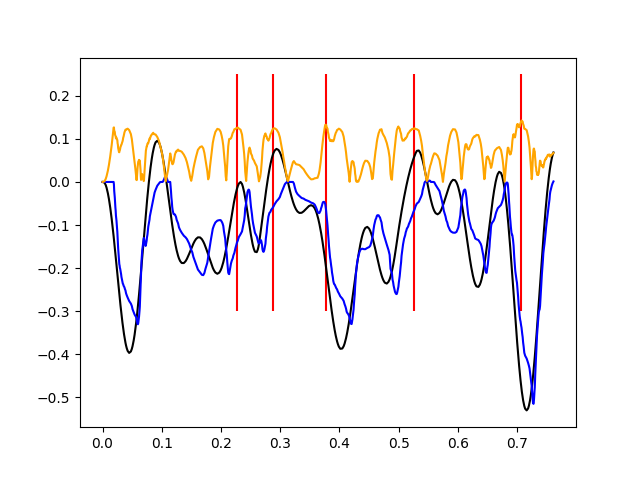

<IPython.core.display.Javascript object>


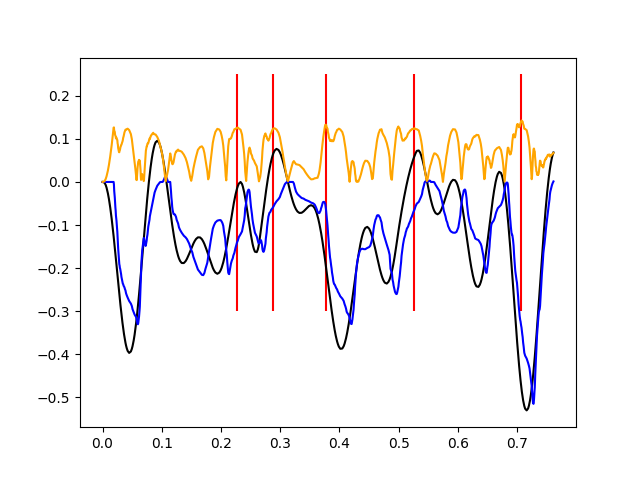

<IPython.core.display.Javascript object>


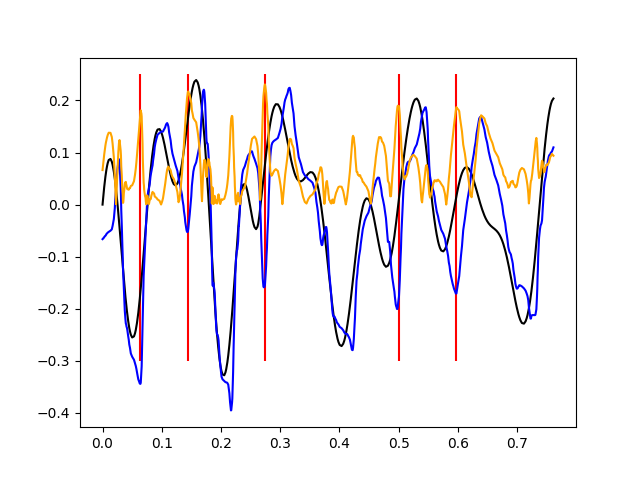

<IPython.core.display.Javascript object>


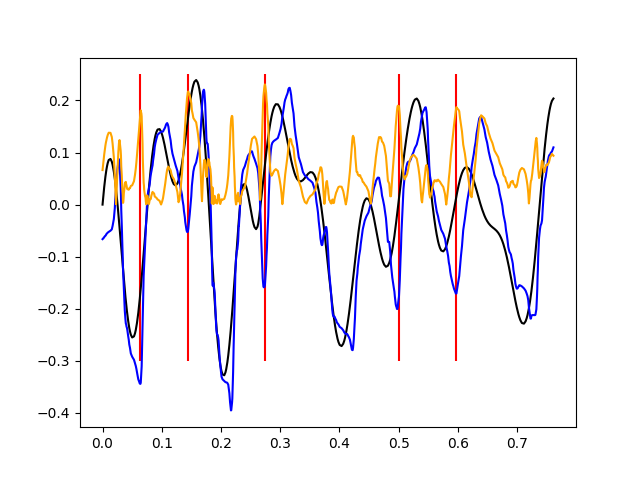

<IPython.core.display.Javascript object>


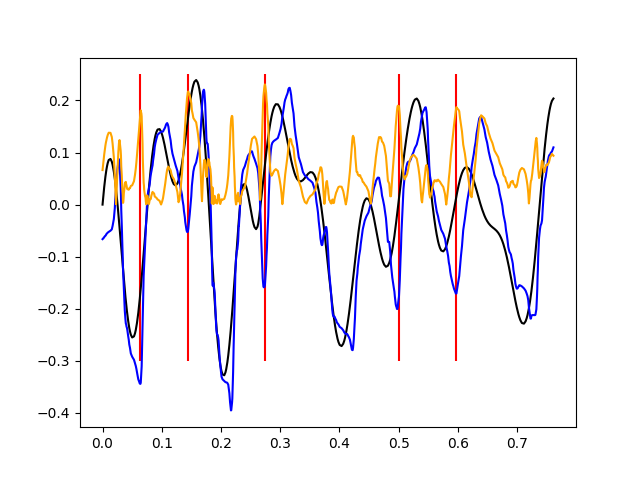

<IPython.core.display.Javascript object>


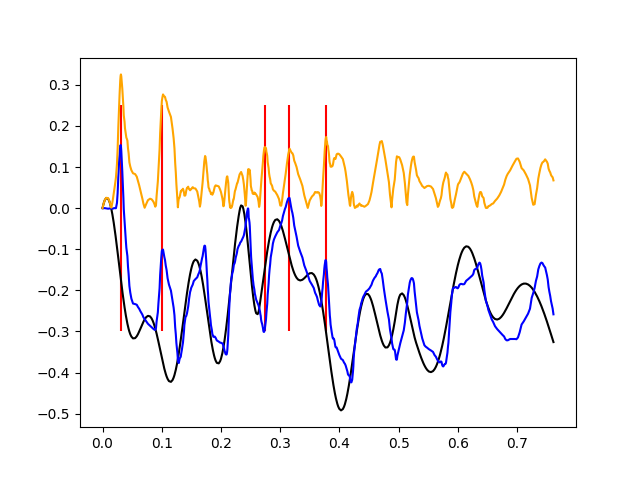

<IPython.core.display.Javascript object>


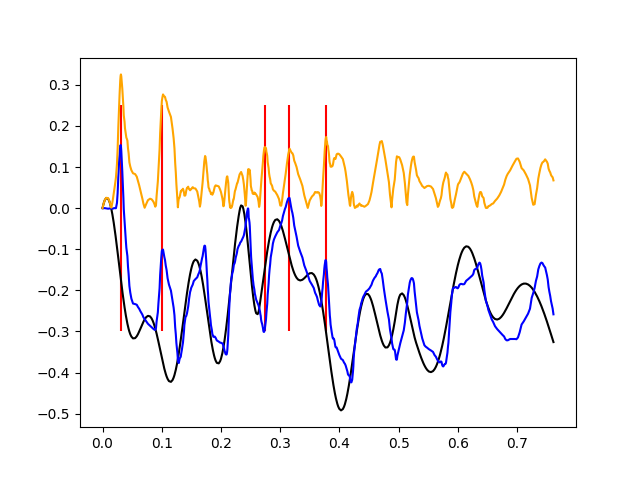

<IPython.core.display.Javascript object>


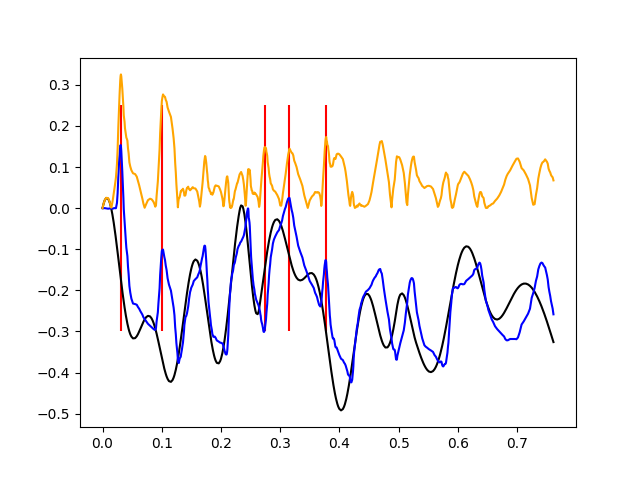

<IPython.core.display.Javascript object>


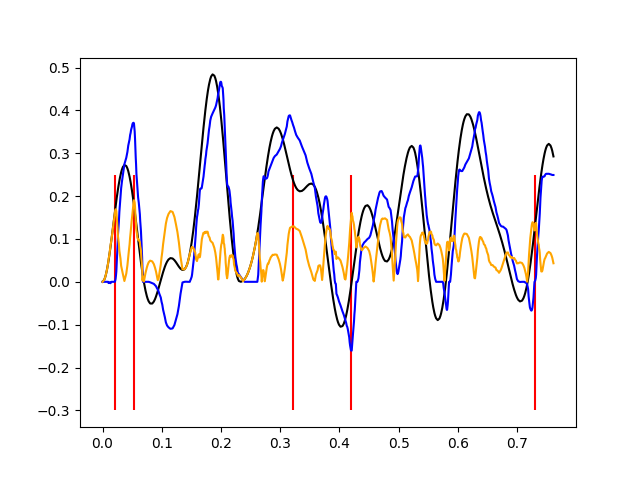

<IPython.core.display.Javascript object>


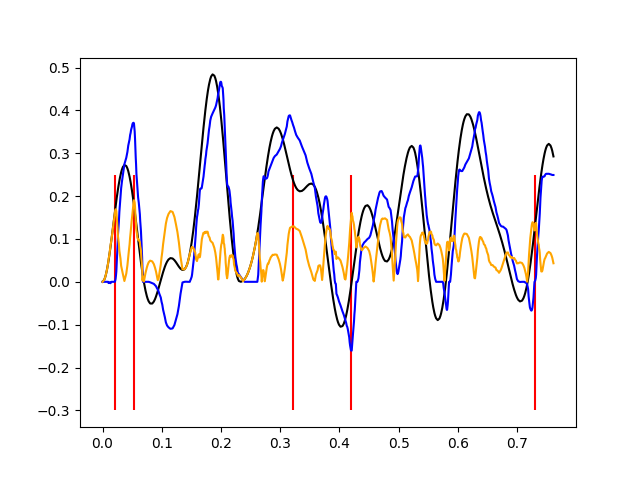

<IPython.core.display.Javascript object>


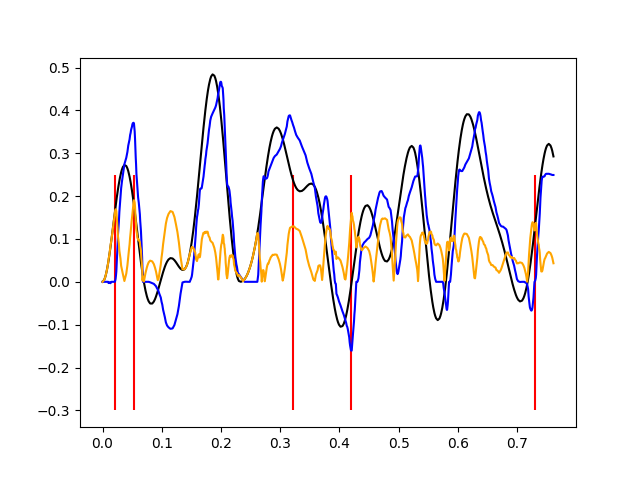

In [43]:
for sbj_ind in range(7,11):
    for task in ["A","B","C"]:
        try:
            deviant_behavior_to_EEG(sbj_ind, task)
        except:
            print(f"skipping Pilot{sbj_ind}_{task}")
            continue